In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import sys
import os
py_file_location = "/content/gdrive/My Drive/PGD"
sys.path.append(os.path.abspath(py_file_location))

In [4]:
cd './gdrive/My Drive/PGD'

/content/gdrive/My Drive/PGD


In [5]:
!pwd

/content/gdrive/My Drive/PGD


In [6]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms, datasets
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np

In [7]:
!nvidia-smi

Mon Feb 21 07:25:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [9]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.version.cuda)

True
0
11.1


In [10]:
class PGD():
  def __init__(self,model,eps=0.3,alpha=2/255,steps=40,random_start=True):
    self.eps = eps
    self.model = model
    self.attack = "Projected Gradient Descent"
    self.alpha = alpha
    self.steps = steps
    self.random_start = random_start
    self.supported_mode = ["default"]
  
  def forward(self,images,labels):
    images = images.clone().detach()
    labels = labels.clone().detach()


    loss = nn.CrossEntropyLoss()

    adv_images = images.clone().detach()

    if self.random_start:
        adv_images = adv_images + torch.empty_like(adv_images).uniform_(-self.eps, self.eps)
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

    for step in range(self.steps):
        adv_images.requires_grad = True
        outputs = self.model(adv_images)
        cost = loss(outputs, labels)
        grad = torch.autograd.grad(cost, adv_images,retain_graph=False, create_graph=False)[0]

        adv_images = adv_images.detach() + self.alpha*grad.sign()
        delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
        adv_images = torch.clamp(images + delta, min=0, max=1).detach()

    return adv_images

In [11]:
class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet,self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    self.maxpool = nn.MaxPool2d(2)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(1024, 10)

  def forward(self,x):
    x = self.conv1(x)
    x = self.maxpool(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.maxpool(x)
    x = self.relu(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    # x = F.softmax(x)
    return x

In [12]:
train = datasets.MNIST('./data/', train=True,
                       transform=transforms.Compose([transforms.ToTensor(),]),
                       download=True)
train_loader = DataLoader(train, batch_size=128)

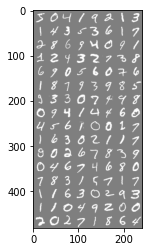

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7,
        1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0,
        7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0,
        2, 0, 2, 7, 1, 8, 6, 4])


In [13]:
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(labels)

In [14]:
model = NeuralNet()
print("Model structure: ", model, "\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure:  NeuralNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
) 


Layer: conv1.weight | Size: torch.Size([32, 1, 5, 5]) | Values : tensor([[[[ 0.0520, -0.0004, -0.1555,  0.1585,  0.1092],
          [-0.0871,  0.0534, -0.1323,  0.0423, -0.1305],
          [-0.1503, -0.0321,  0.1922, -0.1547,  0.1637],
          [-0.1839,  0.1445,  0.1149,  0.0307, -0.1898],
          [ 0.1601, -0.1221, -0.0558, -0.0603, -0.0053]]],


        [[[ 0.0147,  0.0210,  0.1376, -0.1522,  0.0437],
          [ 0.0757,  0.0896, -0.1792,  0.1930,  0.0768],
          [ 0.0717,  0.1302,  0.1222, -0.0159, -0.0720],
          [-0.1753, -0.0094,  0.0450, -0.0539,  0.0006],
          [ 0.1306,  0.1161,  0.0854,  0.1446, -0.0198]]]],
       grad_fn=<SliceBackward0>) 

L

In [15]:
model.train()
optimiser = optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

In [16]:
for epoch in range(10):
  epoch_loss = 0
  correct, total = 0,0
  for i,data in enumerate(train_loader,0):
    inputs,labels = data
    optimiser.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs,labels)
    loss.backward()
    optimiser.step()
    epoch_loss += loss.item()
    pred = torch.max(outputs,1)
    total += labels.size(0)
    correct += (pred.indices == labels).sum().item()
  print("Epoch:",epoch+1, " Loss: ",epoch_loss," Accuracy:",correct/total)

Epoch: 1  Loss:  133.19387858873233  Accuracy: 0.9178666666666667
Epoch: 2  Loss:  39.83447671192698  Accuracy: 0.97425
Epoch: 3  Loss:  29.452317295828834  Accuracy: 0.9812833333333333
Epoch: 4  Loss:  24.33678914484335  Accuracy: 0.9845333333333334
Epoch: 5  Loss:  21.026371919782832  Accuracy: 0.9867833333333333
Epoch: 6  Loss:  18.535167414927855  Accuracy: 0.9885666666666667
Epoch: 7  Loss:  16.609494662028737  Accuracy: 0.9900833333333333
Epoch: 8  Loss:  15.03074765909696  Accuracy: 0.99095
Epoch: 9  Loss:  13.682707965606824  Accuracy: 0.9917666666666667
Epoch: 10  Loss:  12.497730019589653  Accuracy: 0.99255


In [17]:
os.makedirs('./model',exist_ok=True)

In [18]:
torch.save(model.state_dict(), './model/pdg_net.pth')

In [19]:
model.load_state_dict(torch.load('./model/pdg_net.pth'))

<All keys matched successfully>

In [20]:
di = iter(train_loader)
sample_images, sample_labels = di.next()

with torch.no_grad():
  op = model(sample_images)
  _,p = torch.max(op.data, dim = 1)
  print(p.shape,sample_labels.shape,sample_images.shape)

torch.Size([128]) torch.Size([128]) torch.Size([128, 1, 28, 28])


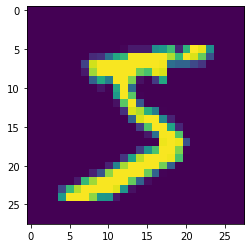

Actual Label: 5 Predicted Label: 5



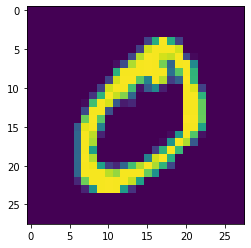

Actual Label: 0 Predicted Label: 0



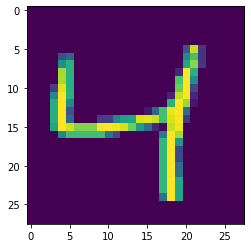

Actual Label: 4 Predicted Label: 4



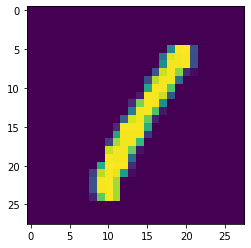

Actual Label: 1 Predicted Label: 1



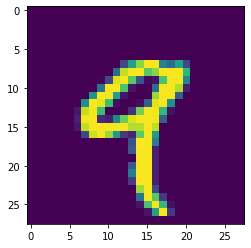

Actual Label: 9 Predicted Label: 9



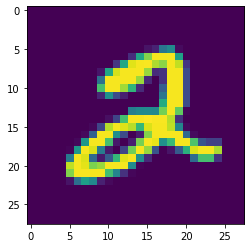

Actual Label: 2 Predicted Label: 2



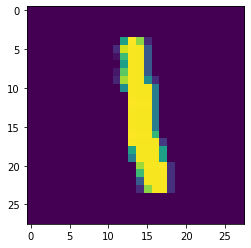

Actual Label: 1 Predicted Label: 1



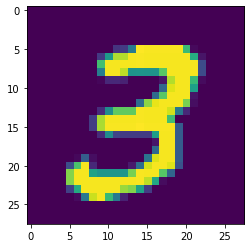

Actual Label: 3 Predicted Label: 3



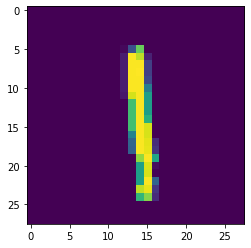

Actual Label: 1 Predicted Label: 1



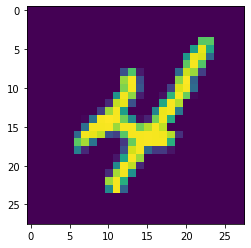

Actual Label: 4 Predicted Label: 4



In [21]:
count = 0
for img,y,y_pred in zip(sample_images,sample_labels,p):
  mg = img / 2 + 0.5  
  npimg = img.numpy()
  plt.imshow(np.squeeze(np.transpose(npimg, (1, 2, 0))))
  plt.show()
  count += 1
  print("Actual Label:", int(y), "Predicted Label:", int(y_pred))
  print()
  if(count>=10):
    break

In [22]:
iter_attack = iter(train_loader)
atk_images, atk_labels = iter_attack.next()
pgd = PGD(model = model)
x_adv = pgd.forward(atk_images,atk_labels)
adv_op = model(x_adv)
_,p_adv = torch.max(adv_op, dim = 1)

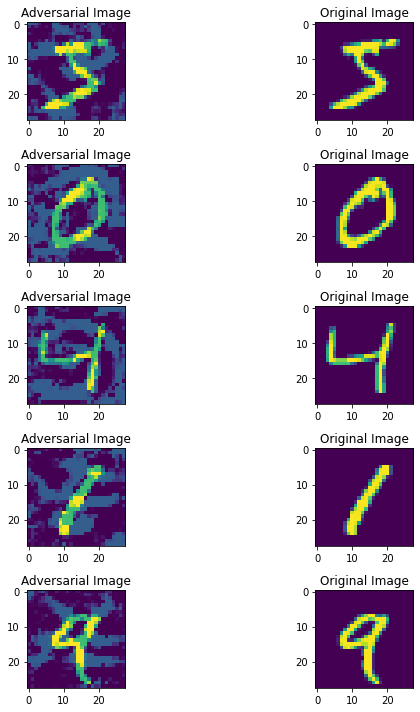

In [23]:
f, axarr = plt.subplots(5,2,figsize=(10,10))
for i,img in enumerate(zip(x_adv,atk_images)):
  img1,img2 = img
  img1,img2 = img1 / 2 + 0.5, img2/2 + 0.5  
  npimg1,npimg2 = img1.numpy(),img2.numpy()
  axarr[i,0].imshow(np.squeeze(np.transpose(npimg1, (1, 2, 0))))
  axarr[i, 0].set_title("Adversarial Image")
  axarr[i,1].imshow(np.squeeze(np.transpose(npimg2, (1, 2, 0))))
  axarr[i,1].set_title("Original Image")
  if(i>=4):
    break
f.tight_layout()
plt.show()

In [24]:
adv_pred = torch.max(adv_op,1)
correct = (adv_pred.indices == atk_labels).sum()
total = len(adv_op)
print(int(correct),total)
print("Accuracy after PGD attack:",(int(correct)/total))

0 128
Accuracy after PGD attack: 0.0


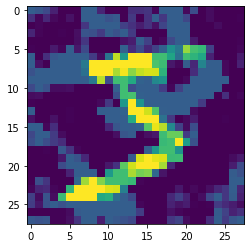

Actual Label: 5 Predicted Label: 3



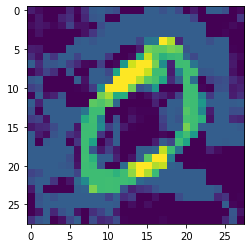

Actual Label: 0 Predicted Label: 2



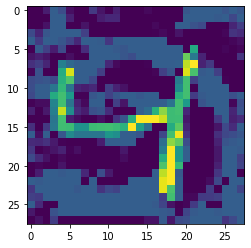

Actual Label: 4 Predicted Label: 9



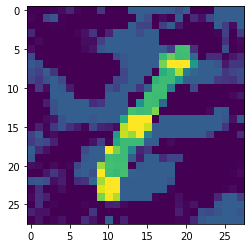

Actual Label: 1 Predicted Label: 8



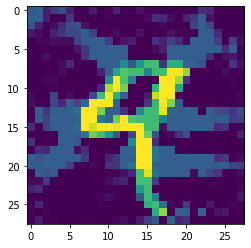

Actual Label: 9 Predicted Label: 4



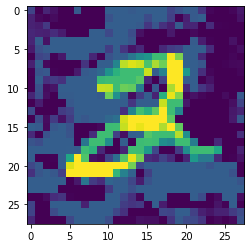

Actual Label: 2 Predicted Label: 3



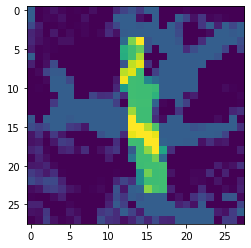

Actual Label: 1 Predicted Label: 4



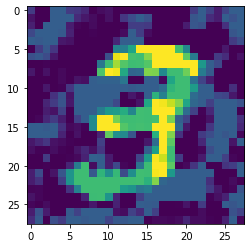

Actual Label: 3 Predicted Label: 9



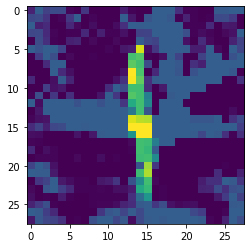

Actual Label: 1 Predicted Label: 4



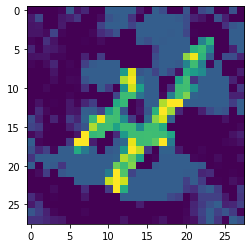

Actual Label: 4 Predicted Label: 8



In [25]:
count = 0
plt.rcParams["figure.figsize"] = (4,4)
for img,y,y_pred in zip(x_adv,atk_labels,adv_pred.indices):
  img = img / 2 + 0.5  
  npimg = img.numpy()
  plt.imshow(np.squeeze(np.transpose(npimg, (1, 2, 0))))
  plt.show()
  count += 1
  print("Actual Label:", int(y), "Predicted Label:", int(y_pred))
  print()
  if(count>=10):
    break

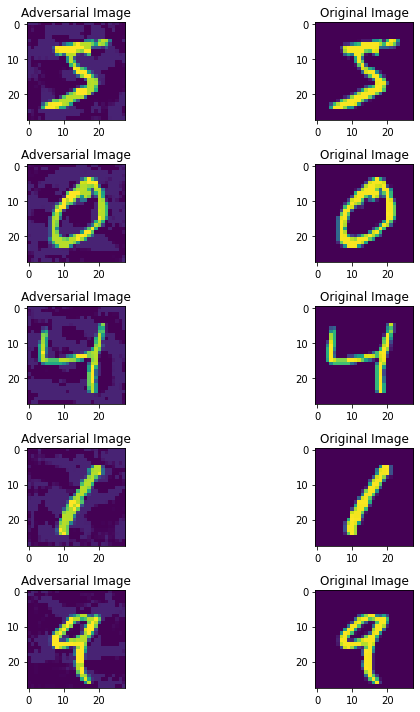

99 128
Accuracy after PGD attack: 0.7734375


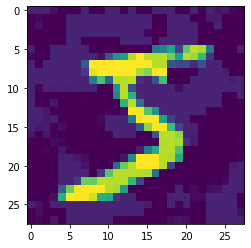

Actual Label: 5 Predicted Label: 3



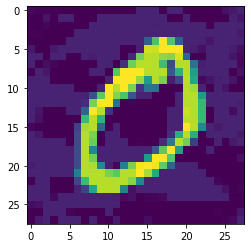

Actual Label: 0 Predicted Label: 0



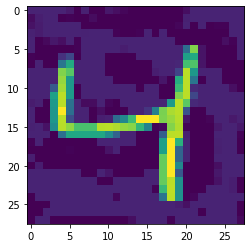

Actual Label: 4 Predicted Label: 4



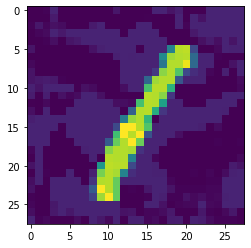

Actual Label: 1 Predicted Label: 1



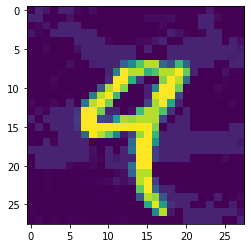

Actual Label: 9 Predicted Label: 4



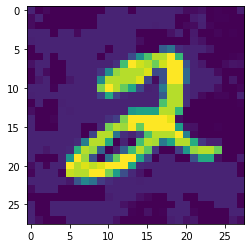

Actual Label: 2 Predicted Label: 2



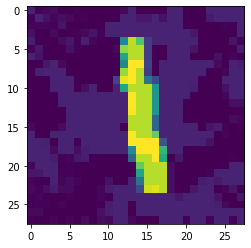

Actual Label: 1 Predicted Label: 1



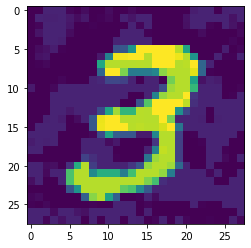

Actual Label: 3 Predicted Label: 3



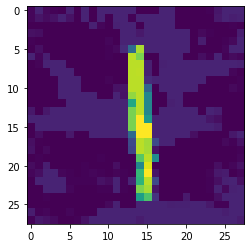

Actual Label: 1 Predicted Label: 1



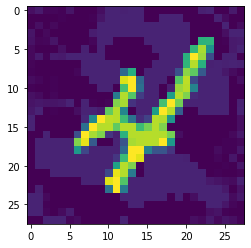

Actual Label: 4 Predicted Label: 4



In [26]:
iter_attack = iter(train_loader)
atk_images, atk_labels = iter_attack.next()
pgd = PGD(model = model,eps = 0.1)
x_adv = pgd.forward(atk_images,atk_labels)
adv_op = model(x_adv)
_,p_adv = torch.max(adv_op, dim = 1)
f, axarr = plt.subplots(5,2,figsize=(10,10))
for i,img in enumerate(zip(x_adv,atk_images)):
  img1,img2 = img
  img1,img2 = img1 / 2 + 0.5, img2/2 + 0.5  
  npimg1,npimg2 = img1.numpy(),img2.numpy()
  axarr[i,0].imshow(np.squeeze(np.transpose(npimg1, (1, 2, 0))))
  axarr[i, 0].set_title("Adversarial Image")
  axarr[i,1].imshow(np.squeeze(np.transpose(npimg2, (1, 2, 0))))
  axarr[i,1].set_title("Original Image")
  if(i>=4):
    break
f.tight_layout()
plt.show()
adv_pred = torch.max(adv_op,1)
correct = (adv_pred.indices == atk_labels).sum()
total = len(adv_op)
print(int(correct),total)
print("Accuracy after PGD attack:",(int(correct)/total))
count = 0
plt.rcParams["figure.figsize"] = (4,4)
for img,y,y_pred in zip(x_adv,atk_labels,adv_pred.indices):
  img = img / 2 + 0.5  
  npimg = img.numpy()
  plt.imshow(np.squeeze(np.transpose(npimg, (1, 2, 0))))
  plt.show()
  count += 1
  print("Actual Label:", int(y), "Predicted Label:", int(y_pred))
  print()
  if(count>=10):
    break